In [10]:
from __future__ import annotations
import argparse
from ast import literal_eval
import json
from pprint import pprint
import sys

from pathlib import Path
from typing import Optional, cast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from eval_pipeline.dataset import TaskType

np.random.seed(42)

from collections import defaultdict

from scipy import stats
from tabulate import tabulate

In [47]:
plt.rcParams.update({'font.size': 12.0})
plt.rcParams.update({'figure.titlesize': 'small'})
plt.rcParams.update({'legend.fontsize': 'small'})

In [25]:
size_dict = {
    "gpt2": 124_000_000,
    "gpt2-medium": 355_000_000,
    "gpt2-large": 774_000_000,
    "gpt2-xl": 1_500_000_000,
    # GPT-3 sizes are based on https://blog.eleuther.ai/gpt3-model-sizes/
    "ada": 350_000_000,
    "babbage": 1_300_000_000,
    "curie": 6_700_000_000,
    "davinci": 175_000_000_000,
    "text-ada-001": 350_000_000,
    "text-babbage-001": 1_300_000_000,
    "text-curie-001": 6_700_000_000,
    "text-davinci-001": 175_000_000_000,
    # gpt neo sizes from their names
    "gpt-neo-125M": 125_000_000,
    "gpt-neo-1.3B": 1_300_000_000,
    "gpt-neo-2.7B": 2_700_000_000,
    "gpt-j-6B": 6_000_000_000,
    # opt sizes from their names
    "opt-125m": 125_000_000,
    "opt-350m": 350_000_000,
    "opt-1.3b": 1_300_000_000,
    "opt-2.7b": 2_700_000_000,
    "opt-6.7b": 6_700_000_000,
    "opt-13b": 13_000_000_000,
    # FLAN-T5 sizes from their names
    "flan-t5-small": 80_000_000,
    "flan-t5-base": 250_000_000,
    "flan-t5-large": 780_000_000,
    "flan-t5-xl": 3_000_000_000,
    "flan-t5-xxl": 11_000_000_000,
    # codegen sizes from their names
    "codegen-350M-mono" : 350_000_000,
    "codegen-2B-mono" : 2_000_000_000,
    "codegen-6B-mono" : 6_000_000_000,
    "codegen-16B-mono" : 16_000_000_000,
    "codegen-350M-multi" : 350_000_000,
    "codegen-2B-multi" : 2_000_000_000,
    "codegen-6B-multi" : 6_000_000_000,
    "codegen-16B-multi" : 16_000_000_000,
    # new OpenAI gpt3 models from their names
    "code-cushman-001": 12_000_000_000,
    "code-davinci-002": 175_000_000_000,
    "text-davinci-002": 175_000_000_000,
    "text-davinci-003": 175_000_000_000, # all the davinci models are the same size
}

In [12]:
def compute_family_loss(family_dir):
    exp_dir = Path(family_dir)
    loss_csvs = [f for f in exp_dir.glob("*.csv") if f.name != "data.csv"]
    dfs = {csv_file.stem: pd.read_csv(csv_file, index_col=0) for csv_file in loss_csvs}
    sizes_rv, mean_losses_rv, standard_errors_rv = [], [], []
    for model_name, df in dfs.items():
        loss_df = df["loss"]
        size = size_dict[model_name]
        sizes_rv.append(size)
        mean_losses_rv.append((size, np.mean(loss_df)))
        standard_errors_rv.append((size, np.std(loss_df) / np.sqrt(len(loss_df))))
    
    sizes_rv.sort()
    mean_losses_rv = [x[1] for x in sorted(mean_losses_rv, key=lambda x: x[0])]
    standard_errors_rv = [x[1] for x in sorted(standard_errors_rv, key=lambda x: x[0])]
    return sizes_rv, mean_losses_rv, standard_errors_rv

In [13]:
def compute_raw_loss(family_dir_list):
    acc = []
    for family_dir in family_dir_list:
        exp_dir = Path(family_dir)
        loss_csvs = [f for f in exp_dir.glob("*.csv") if f.name != "data.csv"]
        dfs = {csv_file.stem: pd.read_csv(csv_file, index_col=0) for csv_file in loss_csvs}
        for model_name, df in dfs.items():
            loss_df = df["loss"]
            size = size_dict[model_name]
            acc.append(np.column_stack([size * np.ones_like(loss_df), np.array(loss_df)]))
    rv = np.vstack(acc).tolist()
    rv.sort(key = lambda x: x[0])
    rv = np.array(rv)
    return rv

In [14]:
def compute_overall_loss(family_dir_list):
    all_loss_dict = defaultdict(list)
    for family_dir in family_dir_list:
        exp_dir = Path(family_dir)
        loss_csvs = [f for f in exp_dir.glob("*.csv") if f.name != "data.csv"]
        dfs = {csv_file.stem: pd.read_csv(csv_file, index_col=0) for csv_file in loss_csvs}
        for model_name, df in dfs.items():
            loss_df = df["loss"]
            size = size_dict[model_name]
            for loss_val in np.array(loss_df):
                all_loss_dict[size].append(loss_val)
    
    acc = []
    for size, loss_list in all_loss_dict.items():
        mean_loss = np.mean(loss_list)
        standard_error = np.std(loss_df) / np.sqrt(len(loss_list))
        acc.append((size, mean_loss, standard_error))
    
    acc.sort(key = lambda x: x[0])
    rv = list(zip(*acc))
    return rv[0], rv[1], rv[2]

In [15]:
#compute_family_loss("./codegen2_from_baskerville/")
sizes, mean_losses, standard_errors = compute_family_loss("./opt/")

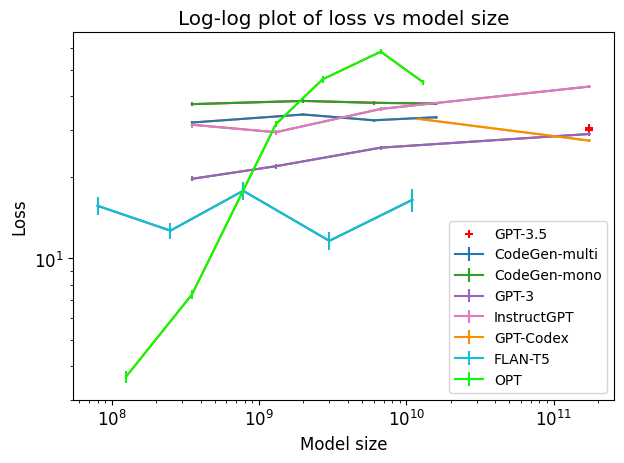

In [53]:
#plt.style.use("ggplot")

plt.xscale("log")
plt.xlabel("Model size")
plt.yscale("log")
plt.ylabel("Loss")
title = "Log-log plot of loss vs model size"

# CodeGen-multi
sizes, mean_losses, standard_errors = compute_family_loss("./codegen_multi_from_baskerville/")
plt.errorbar(sizes, mean_losses, standard_errors, label='CodeGen-multi')
plt.plot(sizes, mean_losses)

# CodeGen-mono
sizes, mean_losses, standard_errors = compute_family_loss("./codegen2_from_baskerville/")
plt.errorbar(sizes, mean_losses, standard_errors, label='CodeGen-mono')
plt.plot(sizes, mean_losses)

# GPT-3
sizes, mean_losses, standard_errors = compute_family_loss("./gpt3/")
plt.errorbar(sizes, mean_losses, standard_errors, label='GPT-3')
plt.plot(sizes, mean_losses)

# InstructGPT
sizes, mean_losses, standard_errors = compute_family_loss("./instruct_gpt3/")
plt.errorbar(sizes, mean_losses, standard_errors, label='InstructGPT')
plt.plot(sizes, mean_losses)

# Codex
sizes, mean_losses, standard_errors = compute_family_loss("./gpt_codex/")
plt.errorbar(sizes, mean_losses, standard_errors, label='GPT-Codex', color="darkorange")
plt.plot(sizes, mean_losses)

# FLAN-T5
sizes, mean_losses, standard_errors = compute_family_loss("./flan_t5/")
plt.errorbar(sizes, mean_losses, standard_errors, label='FLAN-T5')
plt.plot(sizes, mean_losses)

# OPT
sizes, mean_losses, standard_errors = compute_family_loss("./opt/")
plt.errorbar(sizes, mean_losses, standard_errors, label='OPT', color="lime")
plt.plot(sizes, mean_losses)

# GPT-3.5
sizes, mean_losses, standard_errors = compute_family_loss("./new_gpt3/")
plt.scatter(sizes, mean_losses, label='GPT-3.5', color="red", marker="+")

###

plt.title(title)
plt.legend()
plt.tight_layout()
plt.savefig(Path("./", "all_models_loss_plot.svg"), format="svg")
plt.savefig(Path("./", "all_models_loss_plot.png"), format="png")
plt.savefig(Path("./", "all_models_loss_plot.pdf"), format="pdf")

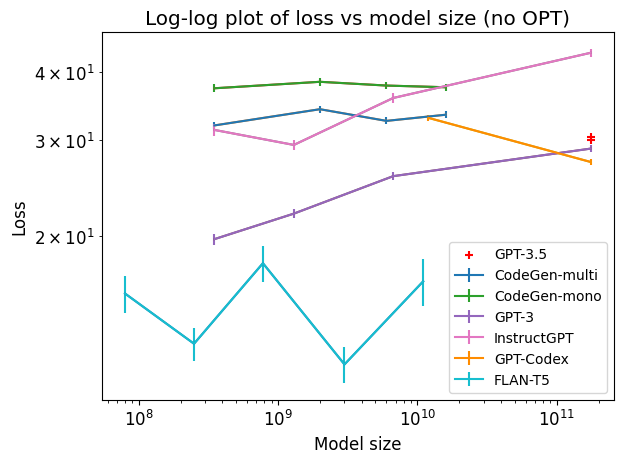

In [54]:
#plt.style.use("ggplot")

plt.xscale("log")
plt.xlabel("Model size")
plt.yscale("log")
plt.ylabel("Loss")
title = "Log-log plot of loss vs model size (no OPT)"

# CodeGen-multi
sizes, mean_losses, standard_errors = compute_family_loss("./codegen_multi_from_baskerville/")
plt.errorbar(sizes, mean_losses, standard_errors, label='CodeGen-multi')
plt.plot(sizes, mean_losses)

# CodeGen-mono
sizes, mean_losses, standard_errors = compute_family_loss("./codegen2_from_baskerville/")
plt.errorbar(sizes, mean_losses, standard_errors, label='CodeGen-mono')
plt.plot(sizes, mean_losses)

# GPT-3
sizes, mean_losses, standard_errors = compute_family_loss("./gpt3/")
plt.errorbar(sizes, mean_losses, standard_errors, label='GPT-3')
plt.plot(sizes, mean_losses)

# InstructGPT
sizes, mean_losses, standard_errors = compute_family_loss("./instruct_gpt3/")
plt.errorbar(sizes, mean_losses, standard_errors, label='InstructGPT')
plt.plot(sizes, mean_losses)

# Codex
sizes, mean_losses, standard_errors = compute_family_loss("./gpt_codex/")
plt.errorbar(sizes, mean_losses, standard_errors, label='GPT-Codex', color="darkorange")
plt.plot(sizes, mean_losses)

# FLAN-T5
sizes, mean_losses, standard_errors = compute_family_loss("./flan_t5/")
plt.errorbar(sizes, mean_losses, standard_errors, label='FLAN-T5')
plt.plot(sizes, mean_losses)

# GPT-3.5
sizes, mean_losses, standard_errors = compute_family_loss("./new_gpt3/")
plt.scatter(sizes, mean_losses, label='GPT-3.5', color="red", marker="+")

###

plt.title(title)
plt.legend()
plt.tight_layout()
plt.savefig(Path("./", "all_models_no_opt_loss_plot.svg"), format="svg")
plt.savefig(Path("./", "all_models_no_opt_loss_plot.png"), format="png")
plt.savefig(Path("./", "all_models_no_opt_loss_plot.pdf"), format="pdf")

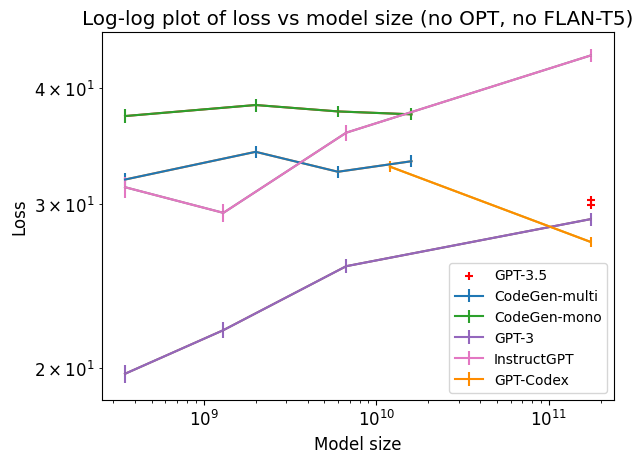

In [55]:
#plt.style.use("ggplot")

plt.xscale("log")
plt.xlabel("Model size")
plt.yscale("log")
plt.ylabel("Loss")
title = "Log-log plot of loss vs model size (no OPT, no FLAN-T5)"

# CodeGen-multi
sizes, mean_losses, standard_errors = compute_family_loss("./codegen_multi_from_baskerville/")
plt.errorbar(sizes, mean_losses, standard_errors, label='CodeGen-multi')
plt.plot(sizes, mean_losses)

# CodeGen-mono
sizes, mean_losses, standard_errors = compute_family_loss("./codegen2_from_baskerville/")
plt.errorbar(sizes, mean_losses, standard_errors, label='CodeGen-mono')
plt.plot(sizes, mean_losses)

# GPT-3
sizes, mean_losses, standard_errors = compute_family_loss("./gpt3/")
plt.errorbar(sizes, mean_losses, standard_errors, label='GPT-3')
plt.plot(sizes, mean_losses)

# InstructGPT
sizes, mean_losses, standard_errors = compute_family_loss("./instruct_gpt3/")
plt.errorbar(sizes, mean_losses, standard_errors, label='InstructGPT')
plt.plot(sizes, mean_losses)

# Codex
sizes, mean_losses, standard_errors = compute_family_loss("./gpt_codex/")
plt.errorbar(sizes, mean_losses, standard_errors, label='GPT-Codex', color="darkorange")
plt.plot(sizes, mean_losses)

# GPT-3.5
sizes, mean_losses, standard_errors = compute_family_loss("./new_gpt3/")
plt.scatter(sizes, mean_losses, label='GPT-3.5', color="red", marker="+")

###

plt.title(title)
plt.legend()
plt.tight_layout()
plt.savefig(Path("./", "all_models_no_opt_no_flan_t5_loss_plot.svg"), format="svg")
plt.savefig(Path("./", "all_models_no_opt_no_flan_t5_loss_plot.png"), format="png")
plt.savefig(Path("./", "all_models_no_opt_no_flan_t5_loss_plot.pdf"), format="pdf")

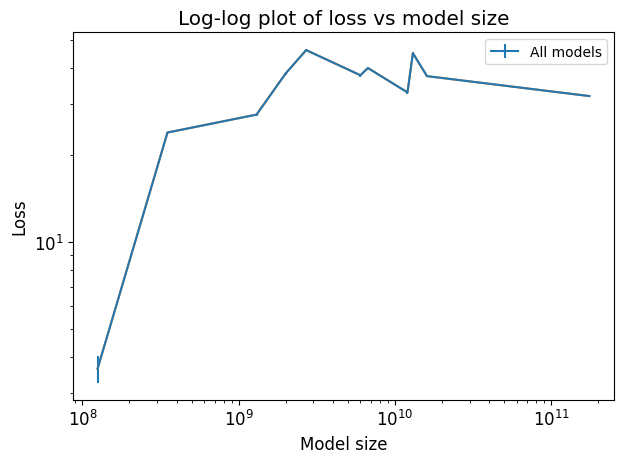

In [56]:
plt.xscale("log")
plt.xlabel("Model size")
plt.yscale("log")
plt.ylabel("Loss")
title = "Log-log plot of loss vs model size"

# All models
sizes, mean_losses, standard_errors = compute_overall_loss(["./opt/",
                                                            "./flan_t5/"
                                                            "./codegen_multi_from_baskerville/",
                                                            "./codegen2_from_baskerville/",
                                                            "./gpt3/",
                                                            "./instruct_gpt3/",
                                                            "./gpt_codex/",
                                                            "./new_gpt3/"])
plt.errorbar(sizes, mean_losses, standard_errors, label='All models')
plt.plot(sizes, mean_losses)

plt.title(title)
plt.legend()
plt.tight_layout()

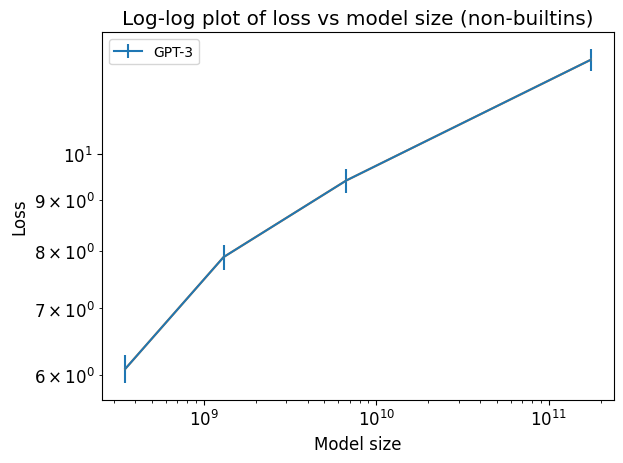

In [58]:
#plt.style.use("ggplot")

plt.xscale("log")
plt.xlabel("Model size")
plt.yscale("log")
plt.ylabel("Loss")
title = "Log-log plot of loss vs model size (non-builtins)"

# GPT-3
sizes, mean_losses, standard_errors = compute_family_loss("./not_builtins/gpt3/")
plt.errorbar(sizes, mean_losses, standard_errors, label='GPT-3')
plt.plot(sizes, mean_losses)

###

plt.title(title)
plt.legend()
plt.tight_layout()
plt.savefig(Path("./", "non_builtins_gpt3_loss_plot.svg"), format="svg")
plt.savefig(Path("./", "non_builtins_gpt3_loss_plot.png"), format="png")
plt.savefig(Path("./", "non_builtins_gpt3_loss_plot.pdf"), format="pdf")

Per-family scaling correlations

In [83]:
def latexify(val, pvalue):
    rv = "{0:.2f}".format(val)
    if ((val > 0.0) and (pvalue < 0.1)):
        rv = "\\textbf{"+rv+"}"
#    if pvalue < 0.2:
#        rv += "*"
#    if pvalue < 0.1:
#        rv += "*"
    rv += " (p=%.2f)" % pvalue
    return rv

def compute_family_correlation_coefficients(sizes, mean_losses):
    rv = []

    s, p = stats.pearsonr(np.log(sizes), np.log(mean_losses))
    rv.append(latexify(s, p))
    s, p = stats.spearmanr(np.log(sizes), np.log(mean_losses))
    rv.append(latexify(s, p))
    s, p = stats.kendalltau(np.log(sizes), np.log(mean_losses))
    rv.append(latexify(s, p))
    
    return rv

In [84]:
table = []

# OPT
sizes, mean_losses, standard_errors = compute_family_loss("./opt/")
row = compute_family_correlation_coefficients(sizes, mean_losses)
table.append(["OPT"] + row)

# GPT-3
sizes, mean_losses, standard_errors = compute_family_loss("./gpt3/")
row = compute_family_correlation_coefficients(sizes, mean_losses)
table.append(["GPT-3"] + row)

# InstructGPT
sizes, mean_losses, standard_errors = compute_family_loss("./instruct_gpt3/")
row = compute_family_correlation_coefficients(sizes, mean_losses)
table.append(["InstructGPT"] + row)

# CodeGen-multi
sizes, mean_losses, standard_errors = compute_family_loss("./codegen_multi_from_baskerville/")
row = compute_family_correlation_coefficients(sizes, mean_losses)
table.append(["CodeGen-multi"] + row)

# CodeGen-mono
sizes, mean_losses, standard_errors = compute_family_loss("./codegen2_from_baskerville/")
row = compute_family_correlation_coefficients(sizes, mean_losses)
table.append(["CodeGen-mono"] + row)

# Codex
sizes, mean_losses, standard_errors = compute_family_loss("./gpt_codex/")
row = compute_family_correlation_coefficients(sizes, mean_losses)
table.append(["GPT-Codex"] + row)

# FLAN-T5
sizes, mean_losses, standard_errors = compute_family_loss("./flan_t5/")
row = compute_family_correlation_coefficients(sizes, mean_losses)
table.append(["FLAN-T5"] + row)

###
#print(table)

headers=["Model family", "Pearson r", "Spearman r", "Kendall $\\tau$"]
tt = tabulate(table, headers, tablefmt="latex_raw")
print(tt)

\begin{tabular}{llll}
\hline
 Model family   & Pearson r              & Spearman r             & Kendall $\tau$         \\
\hline
 OPT            & \textbf{0.94} (p=0.01) & \textbf{0.83} (p=0.04) & \textbf{0.73} (p=0.06) \\
 GPT-3          & \textbf{0.97} (p=0.03) & \textbf{1.00} (p=0.00) & \textbf{1.00} (p=0.08) \\
 InstructGPT    & \textbf{0.94} (p=0.06) & 0.80 (p=0.20)          & 0.67 (p=0.33)          \\
 CodeGen-multi  & 0.46 (p=0.54)          & 0.40 (p=0.60)          & 0.33 (p=0.75)          \\
 CodeGen-mono   & 0.10 (p=0.90)          & 0.20 (p=0.80)          & 0.00 (p=1.00)          \\
 GPT-Codex      & -1.00 (p=1.00)         & -1.00 (p=nan)          & -1.00 (p=1.00)         \\
 FLAN-T5        & 0.01 (p=0.99)          & 0.10 (p=0.87)          & 0.00 (p=1.00)          \\
\hline
\end{tabular}
